# Theano implementation of Poisson glmnet using cyclical coordinate descent

Jerome Friedman, Trevor Hastie and Rob Tibshirani. (2008).
Regularization Paths for Generalized Linear Models via Coordinate Descent.
Journal of Statistical Software, Vol. 33(1), 1-22

In [19]:
import numpy as np
from scipy.special import expit
import scipy.sparse as sps
import matplotlib.pyplot as plt
%matplotlib inline

## Linear nonlinear Poisson-like GLM with elastic net penalty

### Poisson GLM
For the Poisson generalized linear model (GLM), $\lambda_i$ is the rate parameter of an inhomogeneous linear-nonlinear Poisson (LNP) process with instantaneous mean given by:

$$\lambda_i = \exp(\beta_0 + \beta^T x_i)$$

where $x_i \in \mathcal{R}^{p \times 1}, i = \{1, 2, \dots, n\}$ are the observed independent variables (predictors), $\beta_0 \in \mathcal{R}^{1 \times 1}$, $\beta \in \mathcal{R}^{p \times 1}$ are linear coefficients. $\lambda_i$ is also known as the conditional intensity function, conditioned on $(\beta_0, \beta)$ and $q(z) = \exp(z)$ is the nonlinearity.

For numerical reasons, let's adopt a stabilizing non-linearity [adopted by Liam Paninski's group] $q(z) = \log(1+\exp(z))$ that prevents the $\lambda_i$ terms from exploding when the argument to the exponent is large. In this modification, the formulation is no longer an exact LNP, nor an exact GLM, but $\pm\mathcal{L}(\beta_0, \beta)$ is still concave (convex) and we can use gradient ascent (descent) to optimize it.

$$\lambda_i = q(\beta_0 + \beta^T x_i) = \log(1 + \exp(\beta_0 + \beta^T x_i))$$

[Refer to Sara Solla's GLM lectures concerning moment generating functions and strict definitions of GLMs]

In [2]:
# Let's define the conditional intensity function
def qu(z):
    #eps = np.finfo(float).eps
    eps = 0.1
    return np.log(1+eps+np.exp(z))

def lmb(beta0, beta, x):
    #eps = np.finfo(float).eps
    eps = 0.1
    z = beta0 + np.dot(x, beta)
    return np.log(1+eps+np.exp(z))   

### Log-likelihood
The likelihood of observing the spike count $y_i$ under the Poisson likelihood function with inhomogeneous rate $\lambda_i$ is given by:

\begin{equation}
\prod_i P(y = y_i) = \prod_i \frac{e^{-\lambda_i} \lambda_i^{y_i}}{y_i!}
\end{equation}

The log-likelihood is given by:

$$\mathcal{L} = \sum_i \bigg\{y_i \log(\lambda_i) - \lambda_i - log(y_i!)\bigg\}$$

However, we are interested in maximizing the log-likelihood as a function of $\beta_0$ and $\beta$. Thus, we can drop the factorial term:

$$\mathcal{L}(\beta_0, \beta) = \sum_i \bigg\{y_i \log(\lambda_i) - \lambda_i\bigg\}$$

In [70]:
# Let's define the log likelihood
def logL(beta0, beta, x, y):
    l = lmb(beta0, beta, x)
    logL = np.sum(y*np.log(l) - l)
    return logL

### Elastic net penalty
For large models we need to penalize the log likelihood term in order to prevent overfitting. 
The elastic net penalty is given by:

$$\mathcal{P}_\alpha(\beta) = (1-\alpha)\frac{1}{2} \|\beta\|^2_{\mathcal{l}_2} + \alpha\|\beta\|_{\mathcal{l}_1}$$

The elastic net interpolates between two extremes. $\alpha = 0$ is known as ridge regression and $\alpha = 1$ is known as Lasso. Note that we do not penalize the baseline term $\beta_0$.

In [4]:
# Let's define the penalty term
def penalty(alpha, beta):
    P = 0.5*(1-alpha)*np.linalg.norm(beta,2) + alpha*np.linalg.norm(beta,1)
    return P

### Objective function
We minimize the objective function:

$$J(\beta_0, \beta) = -\mathcal{L}(\beta_0, \beta) + \lambda \mathcal{P}_\alpha(\beta)$$

where $\mathcal{L}(\beta_0, \beta)$ is the Poisson log-likelihood and $\mathcal{P}_\alpha(\beta)$ is the elastic net penalty term and $\lambda$ and $\alpha$ are regularization parameters.


In [5]:
# Let's define the objective function with elastic net regularization
def loss(beta0, beta, alpha, reg_lambda, x, y):
    L = logL(beta0, beta, x, y)
    P = penalty(alpha, beta)
    J = -L + reg_lambda*P
    return J

## Optimization

### Gradients
To calculate the gradients of the cost function with respect to $\beta_0$ and $\beta$, let's plug in the definitions for the log likelihood and penalty terms from above.

$$
J(\beta_0, \beta) = \sum_i \bigg\{ \log(1 + \exp(\beta_0 + \beta^T x_i)) - y_i \log(\log(1 + \exp(\beta_0 + \beta^T x_i)))\bigg\} + \lambda(1-\alpha)\frac{1}{2} \|\beta\|^2_{\mathcal{l_2}} + \lambda\alpha\|\beta\|_{\mathcal{l_1}}
$$

Since we will apply co-ordinate descent, let's rewrite this cost in terms of each scalar parameter $\beta_j$

$$
J(\beta_0, \beta) = \sum_i \bigg\{ \log(1 + \exp(\beta_0 + \sum_j \beta_j x_{ij})) - y_i \log(\log(1 + \exp(\beta_0 + \sum_j \beta_j x_{ij})))\bigg\} + \lambda(1-\alpha)\frac{1}{2} \sum_j \beta_j^2 + \lambda\alpha\sum_j \mid\beta_j\mid
$$

Let's take the derivatives of some big expressions using chain rule. Define $z_i = \beta_0 + \sum_j \beta_j x_{ij}$.

For the nonlinearity in the first term $y = q(z) = \log(1+e^{z(\theta)})$,

$$\frac{\partial y}{\partial \theta} = \frac{\partial q}{\partial z}\frac{\partial z}{\partial \theta} = \frac{e^z}{1+e^z}\frac{\partial z}{\partial \theta} = \sigma(z)\frac{\partial z}{\partial \theta}$$

For the nonlinearity in the second term $y = \log(q(z)) = \log(\log(1+e^{z(\theta)}))$,

$$\frac{\partial y}{\partial \theta} = \frac{1}{q(z)}\frac{\partial q}{\partial z}\frac{\partial z}{\partial \theta} = \frac{\sigma(z)}{q(z)}\frac{\partial z}{\partial \theta}$$

where $\dot q(z)$ happens to be be the sigmoid function,
$$\sigma(z) = \frac{e^z}{1+e^z}$$

Putting it all together, we have,

$$
\frac{\partial J}{\partial \beta_0} = \sum_i \sigma(z_i) - \sum_i y_i\frac{\sigma(z_i)}{q(z_i)}
$$

$$
\frac{\partial J}{\partial \beta_j} = \sum_i \sigma(z_i) x_{ij} - \sum_i y_i \frac{\sigma(z_i)}{q(z_i)}x_{ij}
+ \lambda(1-\alpha)\beta_j + \lambda\alpha \text{sgn}(\beta_j)
$$


In [6]:
# Let's define these gradients
def grad_loss(beta0, beta, alpha, reg_lambda, x, y):
    z = beta0 + np.dot(x, beta)
    q = qu(z)
    s = expit(z)
    grad_beta0 = np.sum(s) - np.sum(y*s/q)
    # This is a matrix implementation
    grad_beta = np.transpose(np.dot(np.transpose(s), x) - np.dot(np.transpose(y*s/q), x)) \
        + reg_lambda*(1-alpha)*beta# + reg_lambda*alpha*np.sign(beta)
    return grad_beta0, grad_beta

### Hessian terms
Second-order derivatives can accelerate convergence to local minima by providing optimal step sizes. However, they are expensive to compute. 

This is where co-ordinate descent shines. Since we update only one parameter $\beta_j$ per step, we can simply use the $j^{th}$ diagonal term in the Hessian matrix to perform an approximate Newton update as:

$$\beta_j^{t+1} = \beta_j^{t} - \bigg\{\frac{\partial^2 J}{\partial \beta_j^2}\bigg\}^{-1} \frac{\partial J}{\partial \beta_j}$$

Let's use calculus again to compute these diagonal terms. Recall that:

$$\dot q(z) = \sigma(z)$$ and 
$$\dot\sigma(z) = \sigma(z)(1-\sigma(z))$$

Using these, and applying the product rule
$$
\frac{\partial}{\partial z}\bigg\{ \frac{\sigma(z)}{q(z)} \bigg\} = \frac{\sigma(z)(1-\sigma(z))}{q(z)} - \frac{\sigma(z)}{q(z)^2}
$$

Plugging all these in, we get
$$
\frac{\partial^2 J}{\partial \beta_0^2} = \sum_i \sigma(z_i)(1 - \sigma(z_i)) - \sum_i y_i \bigg\{ \frac{\sigma(z_i) (1 - \sigma(z_i))}{q(z_i)} - \frac{\sigma(z_i)}{q(z_i)^2} \bigg\}
$$

$$
\frac{\partial^2 J}{\partial \beta_j^2} = \sum_i \sigma(z_i)(1 - \sigma(z_i)) x_{ij}^2 
- \sum_i y_i \bigg\{ \frac{\sigma(z_i) (1 - \sigma(z_i))}{q(z_i)} - \frac{\sigma(z_i)}{q(z_i)^2} \bigg\}x_{ij}^2 + \lambda(1-\alpha)
$$

In [7]:
# Let's define these Hessian terms
def hessian_loss(beta0, beta, alpha, reg_lambda, x, y):
    z = beta0 + np.dot(x, beta)
    q = qu(z)
    s = expit(z)
    grad_s = s*(1-s)
    grad_s_by_q = grad_s/q - s/(q*q)
    
    hess_beta0 = np.sum(grad_s) - np.sum(y*grad_s_by_q)
    
    # This is a matrix implementation
    hess_beta = np.transpose(np.dot(np.transpose(grad_s), x*x) - np.dot(np.transpose(y*grad_s_by_q), x*x))\
                             + reg_lambda*(1-alpha)
    return hess_beta0, hess_beta

## Cyclical co-ordinate descent

### Parameter update step
In cylical coordinate descent with elastic net, we store an active set, $\mathcal{K}$, of parameter indices that we update. Since the $\mathcal{l}_1$ terms $|\beta_j|$ are not differentiable at zero, we use the gradient without the $\lambda\alpha \text{sgn}(\beta_j)$ term to update $\beta_j$. Let's call these gradient terms $\tilde{g}_k$.

We start by initializing $\mathcal{K}$ to contain all parameter indices
Let's say only the $k^{th}$ parameter is updated at time step $t$.

$$\beta_k^{t} = \beta_k^{t-1} - (h_k^{t-1})^{-1} \tilde{g}_k^{t-1}$$
$$\beta_j^{t} = \beta_j^{t-1}, \forall j \neq k $$

Next, we apply a soft thresholding step for $k \neq 0$ after every update iteration, as follows.
$$\beta_k^{t} = \mathcal{S}_{\lambda\alpha}(\beta_k^{t})$$

where 
$$S_\lambda(x) = 
\begin{cases}
0 & \text{if} & |x| \leq \lambda\\
\text{sgn}(x)||x|-\lambda| & \text{if} & |x| > \lambda
\end{cases}
$$

If $\beta_k^{t}$ has been zero-ed out, we remove $k$ from the active set.
$$
\mathcal{K} = \mathcal{K} \setminus \left\{k\right\}
$$


In [133]:
# Define the proximal operator
def prox(x,l):
    sx = [0. if np.abs(y) <= l else np.sign(y)*np.abs(abs(y)-l) for y in x]
    return np.array(sx).reshape(x.shape)

### Efficient z update

Next, we want to update $\beta_{k+1}$ at the next time step $t+1$. For this we need the gradient and Hessian terms, $\tilde{g}_{k+1}$ and $h_{k+1}$. If we update them instead of recalculating them, we can save on a lot of multiplications and additions. This is possible because we only update one parameter at a time. Let's calculate how to make these updates.

$$z_i^{t} = z_i^{t-1} - \beta_k^{t-1}x_{ik} + \beta_k^{t}x_{ik}$$

$$z_i^{t} = z_i^{t-1} - (h_k^{t-1})^{-1} \tilde{g}_k^{t-1}x_{ik}$$

### Gradient update

If $k = 0$,

$$\tilde{g}_{k+1}^t = \sum_i \sigma(z_i^t) - \sum_i y_i \frac{\sigma(z_i^t)}{q(z_i^t)}$$

If $k > 0$,

$$\tilde{g}_{k+1}^t = \sum_i \sigma(z_i^t) x_{i,k+1} - \sum_i y_i \frac{\sigma(z_i^t)}{q(z_i^t)}x_{i,k+1} + \lambda(1-\alpha)\beta_{k+1}^t$$ 

In [9]:
# Gradient update for a single coordinate
def grad_loss_k(z, beta_k, alpha, rl, xk, y, k):
    q = qu(z)
    s = expit(z)
    
    if(k == 0):
        gk = np.sum(s) - np.sum(y*s/q)
    else:
        gk = np.sum(s*xk) - np.sum(y*s/q*xk) + rl*(1-alpha)*beta_k
    return gk

### Hessian update

If $k = 0$,

$$
h_{k+1}^t = \sum_i \sigma(z_i^t)(1 - \sigma(z_i^t)) 
- \sum_i y_i \bigg\{ \frac{\sigma(z_i^t) (1 - \sigma(z_i^t))}{q(z_i^t)} - \frac{\sigma(z_i^t)}{q(z_i^t)^2} \bigg\}
$$

If $k > 0$,

$$
h_{k+1}^t = \sum_i \sigma(z_i^t)(1 - \sigma(z_i^t)) x_{i,k+1}^2 
- \sum_i y_i \bigg\{ \frac{\sigma(z_i^t) (1 - \sigma(z_i^t))}{q(z_i^t)} - \frac{\sigma(z_i^t)}{q(z_i^t)^2} \bigg\}x_{i,k+1}^2 + \lambda(1-\alpha)
$$


In [306]:
# Hessian update for a single coordinate
def hess_loss_k(z, alpha, rl, xk, y, k):
    q = qu(z)
    s = expit(z)
    grad_s = s*(1-s)
    grad_s_by_q = grad_s/q - s/(q*q)

    if(k == 0):
        hk = np.sum(grad_s) - np.sum(y*grad_s_by_q)
    else:
        hk = np.sum(grad_s*xk*xk) - np.sum(y*grad_s_by_q*xk*xk) + rl*(1-alpha)
    return hk

### Regularization paths and warm restarts

We often find the optimal regularization parameter $\lambda$ through cross-validation. Thus, in practice, we fit the model several times over a range of $\lambda$'s $\{ \lambda_{max} \geq \dots \geq \lambda_0\}$. 

Instead of re-fitting the model each time, we can solve the problem for the most-regularized model ($\lambda_{max}$) and then initialize the subsequent model with this solution. The path that each parameter takes through the range of regularization parameter is known as the regularization path, and the trick of initializing each model with the previous model's solution is known as a warm restart.

In practice, this significantly speeds up convergence.

### Algorithm

Give the algorithm in an algorithm table



## Implementation

### Pathwise cyclical coordinate descent for elastic net regularized GLM

In [257]:
# Native python function
def fitmodel(x, y, reg_lambda, alpha):

    n = x.shape[0]
    p = x.shape[1]
    
    beta0_hat = np.random.normal(0.0,1.0,1)
    beta_hat = np.random.normal(0.0,1.0,[p,1])
    fit = []
        
    # Outer loop with descending lambda
    for l,rl in enumerate(reg_lambda):
        fit.append({'beta0': 0., 'beta': np.zeros([p,1])})
        print('Lambda: {}\n').format(rl)
        
        # Warm initialize parameters
        if(l == 0):
            fit[-1]['beta0'] = beta0_hat
            fit[-1]['beta'] = beta_hat
        else:
            fit[-1]['beta0'] = fit[-2]['beta0']
            fit[-1]['beta'] = fit[-2]['beta']
                
        #---------------------------
        # Iterate until convergence
        #---------------------------
        no_convergence = 1
        convergence_threshold = 1e-3
        c = 0
        
        # Initialize parameters
        beta_prev = np.zeros([p+1,1])
        beta = np.zeros([p+1,1])
        
        beta_prev[0] = beta0_hat[:]
        beta_prev[1:] = beta_hat[:]
        z_prev = beta_prev[0] + np.dot(x, beta_prev[1:])
        z = z_prev
        
        # Initialize gradient/ Hessian
        g = np.zeros([p+1,1])
        h = np.zeros([p+1,1])
        
        grad_beta0, grad_beta = grad_loss(beta0_hat, beta_hat, alpha, rl, x, y)
        g[0] = grad_beta0
        g[1:] = grad_beta
        
        hess_beta0, hess_beta = hessian_loss(beta0_hat, beta_hat, alpha, rl, x, y)
        h[0] = hess_beta0
        h[1:] = hess_beta
        
        # Middle loop for cycles
        L = []
        DL = []
        
        # Initialize active set
        K = range(p)
    
        while(no_convergence):
            # Inner loop for coordinate descent
            print('  Cycle: {}\n'.format(c))
            for k in K:
                if np.mod(k,10) == 0:
                    print('    parameter: {}'.format(k))
                    
                # Update the parameters
                #TODO: include a line search in place of h
                #TODO: include momentum
                beta[k] = beta_prev[k] - g[k]/h[k]
                
                #print 'beta_k: {}'.format(beta[k])
                #print 'lambda*alpha: {}'.format(rl*alpha)
                
                # Soft threshold for k > 0
                if k>0:
                    beta[k] = prox(beta[k], rl*alpha)
                
                #print 'soft thresholded beta_k: {}'.format(beta[k])
                
                #Update z
                z = z_prev - g[k]/h[k]*x[:,k] 
                
                #Calculate gradient
                g[k] = grad_loss_k(z, beta[k], alpha, rl, x[:,k], y, k)
                
                #Calculate Hessian
                h[k] = hess_loss_k(z, alpha, rl, x[:,k], y, k)
                
                # Housekeeping
                beta_prev[k] = beta[k]
                z_prev = z
            
            # Calculate loss and convergence criteria
            L.append(loss(beta[0], beta[1:], alpha, rl, x, y))
            print('    Loss function: {}').format(L[c])
            
            # Update active set
            K = list(set(K) - set([i for (i, val) in enumerate(beta[1:]) if val == 0]))
            print "    Active set size:{}".format(len(K))
            
            # Delta loss and convergence criterion
            if c > 0:
                DL.append(L[c] - L[c-1])
                print('    dL/L: {}').format(DL[-1]/L[-1])
                if(np.abs(DL[-1]/L[-1]) < convergence_threshold):
                    no_convergence = 0
                    print('Converged\n')
            c = c+1
            
        #Store the parameters after convergence
        fit[-1]['beta0'] = beta[0]
        fit[-1]['beta'] = beta[1:]
    
    return fit

### Pathwise proximal batch gradient descent for elastic net regularized GLM

In [310]:
# Native python function
def fitmodel_graddesc(x, y, reg_params, opt_params):
    
    # Implements batch gradient descent (i.e. vanilla gradient descent by computing gradient over entire training set)
    
    # Dataset shape
    n = x.shape[0]
    p = x.shape[1]
    
    # Regularization parameters
    reg_lambda = fit_params['reg_lambda']
    alpha = fit_params['alpha']
    
    # Optimization parameters
    max_iter = opt_params['max_iter']
    e = opt_params['learning_rate']
    p1 = opt_params['p1'] #first order moment decay rate
    p2 = opt_params['p2'] #second order moment decay rate
    
    # Initialize parameters
    beta0_hat = np.random.normal(0.0,1.0,1)
    beta_hat = np.random.normal(0.0,1.0,[p,1])
    fit = []
        
    # Outer loop with descending lambda
    for l,rl in enumerate(reg_lambda):
        fit.append({'beta0': 0., 'beta': np.zeros([p,1])})
        print('Lambda: {}\n').format(rl)
        
        # Warm initialize parameters
        if(l == 0):
            fit[-1]['beta0'] = beta0_hat
            fit[-1]['beta'] = beta_hat
        else:
            fit[-1]['beta0'] = fit[-2]['beta0']
            fit[-1]['beta'] = fit[-2]['beta']
        
        #---------------------------
        # Iterate until convergence
        #---------------------------
        no_convergence = 1
        convergence_threshold = 1e-3
        t = 0
        
        # Initialize parameters
        beta = np.zeros([p+1,1])
        beta[0] = beta0_hat[:]
        beta[1:] = beta_hat[:]
        
        # Initialize moment parameters
        #s = np.zeros([p+1,1])
        #r = np.zeros([p+1,1])
        g = np.zeros([p+1,1])
        
        # Initialize cost
        L = []
        DL = []
    
        while(no_convergence and t < max_iter):
                        
            #Calculate gradient
            grad_beta0, grad_beta = grad_loss(beta[0], beta[1:], alpha, rl, x, y)
            g[0] = grad_beta0
            g[1:] = grad_beta
            
            # Update time step
            t = t+1
            
            # Update moment terms
            #s = p1*s + (1-p1)*g
            #r = p2*r + (1-p2)*g*g

            # Correct bias in moment terms
            #s = s/(1-p1**t)
            #r = r/(1-p2**t)
            
            # Update parameters
            #delta_beta = -np.divide(s, np.sqrt(r) + 1e-6)
            delta_beta = -e*g
            beta = beta + delta_beta
            
            # Apply proximal operator for L1-regularization
            beta[1:] = prox(beta[1:], rl*alpha)
                        
            # Calculate loss and convergence criteria
            L.append(loss(beta[0], beta[1:], alpha, rl, x, y))
            #print('    Loss function: {}').format(L[c])
            
            # Delta loss and convergence criterion
            if t > 1:
                DL.append(L[-1] - L[-2])
                #print('    dL/L: {}').format(DL[-1]/L[-1])
                if(np.abs(DL[-1]/L[-1]) < convergence_threshold):
                    no_convergence = 0
                    print('Converged')
                    print('    Loss function: {}').format(L[-1])
                    print('    dL/L: {}\n').format(DL[-1]/L[-1])
            
        #Store the parameters after convergence
        fit[-1]['beta0'] = beta[0]
        fit[-1]['beta'] = beta[1:]
    
    return fit

## Test on simulated data

### Simulate some data

In [305]:
# Simulate data
from scipy.stats import zscore
N = 100000
p = 1000
x = np.random.normal(0.0, 1.0, [N,p])
beta0 = np.random.normal(0.0, 1.0, 1)
beta = sps.rand(p,1,0.1)
beta = np.array(beta.todense())
y = np.random.poisson(lmb(beta0, beta, zscore(x)))

### Fit the model

In [315]:
from scipy.stats import zscore

# Set regularization parameters
reg_lambda = np.logspace(np.log(0.5), np.log(0.01), 100, base=np.exp(1))
alpha = 0.2

fit_params = dict()
fit_params['reg_lambda'] = [0.02]
fit_params['alpha'] = alpha

# Set optimization parameters
opt_params = dict()
opt_params['learning_rate'] = 1e-4
opt_params['max_iter'] = 1000
opt_params['p1'] = 0.9
opt_params['p2'] = 0.999

fit = fitmodel_graddesc(zscore(x),y,fit_params,opt_params)


Lambda: 0.02

Converged
    Loss function: -125280.741375
    dL/L: 0.00093498364626



### Visualize the estimated model parameters

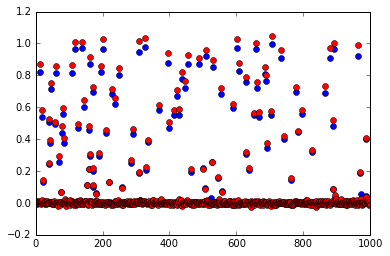

In [316]:
plt.plot(beta[:], 'bo')
plt.hold(True)
plt.plot(fit[0]['beta'][:], 'ro')
plt.show()

### Visualize the training set prediction

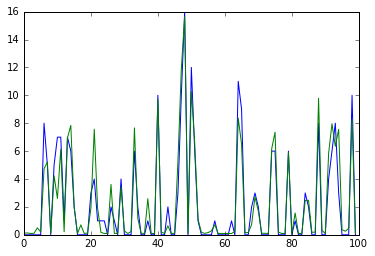

In [323]:
fitparams = fit[0]
yhat = lmb(fitparams['beta0'], fitparams['beta'], zscore(x))
plt.plot(y[:100])
plt.hold(True)
plt.plot(yhat[:100])
plt.show()

### Goodness of fit

In [324]:
np.corrcoef(np.transpose(y), np.transpose(yhat))

array([[ 1.        ,  0.90299887],
       [ 0.90299887,  1.        ]])

### TO-DO List

1. Write a "model" class that has 

    * gradients for normal and poisson [done]
    * a simulate function [done]
    * 'model_compare'
    * user specified 'log-likelihood function' 
    * user specified 'nonlinearity'

2. Translate pyglmnet.py to Theano

3. SGD variant for big data but without pathwise warm restarts
    
    * use dask for data parsing [?]
    * momentum methods
    * adaptive learning rate methods
    
4. Translate SGD variant to Theano

5. Figure out why coordinate descent doesn't converge